# Preprocessing i Training v3.0

In [11]:
# ----------------------------------------------------------------------------------
# CELDA 1 ▸ Imports y utilidades
# ----------------------------------------------------------------------------------
import warnings, json, pickle, pathlib, random, os, sys
import numpy  as np
import pandas as pd
from datetime import datetime
from pprint   import pprint
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     GridSearchCV)
from sklearn.preprocessing   import OneHotEncoder, StandardScaler
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import (accuracy_score, precision_score, recall_score,
                                     f1_score, roc_auc_score, confusion_matrix,
                                     classification_report)

from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network  import MLPClassifier

from imblearn.over_sampling  import RandomOverSampler           # solo MLP
from imblearn.pipeline       import Pipeline as ImbPipeline     # para Oversampler

In [12]:


SEEDS = [42, 77, 2023, 2024, 2025]
DATA_PATH = '../../../03. Datasets/Lifesnaps Fitbit/csv_rais_anonymized/daily_fitbit_sema_df_unprocessed.csv'   # ajusta si tu fichero está en otra ruta

# ----------------------------------------------------------------------------------
# CELDA 2 ▸ Carga de datos y Feature Engineering
# ----------------------------------------------------------------------------------
df = pd.read_csv(DATA_PATH)

# --- Variables de fecha ------------------------------------------------------------
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["day_of_week"] = df["date"].dt.dayofweek
df["month"]       = df["date"].dt.month
df["is_weekend"]  = df["day_of_week"].isin([5, 6]).astype(int)
df.drop(columns=["date"], inplace=True)          # la fecha pura ya no se usa

# --- Nuevas features ---------------------------------------------------------------
df["active_minutes_sum"] = (df["lightly_active_minutes"]
                             + df["moderately_active_minutes"]
                             + df["very_active_minutes"])

df["active_ratio"] = df["active_minutes_sum"] / (df["sedentary_minutes"] + 1)

df["hrv_stress"] = df["rmssd"] / (df["stress_score"] + 1)

# --- Eliminamos columnas irrelevantes o muy vacías ---------------------------------
drop_cols = ["Unnamed: 0", "id", "spo2"]                         # >80 % nulos
target_cols = ["TIRED", "TENSE/ANXIOUS"]

df_features = df.drop(columns = drop_cols + target_cols)
print(f"Dimensión final de X: {df_features.shape}")

# --- Tipos -------------------------------------------------------------------------
for c in df_features.columns:
    if df_features[c].dtype == "object":
        df_features[c] = pd.to_numeric(df_features[c], errors="ignore")

cat_cols  = df_features.select_dtypes(include=["object"]).columns.tolist()
num_cols  = [c for c in df_features.columns if c not in cat_cols]

# ----------------------------------------------------------------------------------
# CELDA 3 ▸ Pre-procesador general
# ----------------------------------------------------------------------------------
numeric_pipe = Pipeline([
    ("imp"   , SimpleImputer(strategy="median")),
    ("scale" , StandardScaler(with_mean=False))        # compatible con sparse
])

categoric_pipe = Pipeline([
    ("imp"   , SimpleImputer(strategy="most_frequent")),
    ("ohe"   , OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe   , num_cols),
    ("cat", categoric_pipe , cat_cols)
])

# ----------------------------------------------------------------------------------
# CELDA 4 ▸ Definición de modelos y grids
# ----------------------------------------------------------------------------------
models = {
    "MLP": (
        ImbPipeline([                       # pipeline especial para oversampling
            ("prep" , preprocess),
            ("ros"  , RandomOverSampler(random_state=0)),
            ("clf"  , MLPClassifier(max_iter=400, early_stopping=True))
        ]),
        {
            "clf__hidden_layer_sizes": [(64,), (128,), (128, 64)],
            "clf__alpha"             : [1e-4, 1e-3],
            "clf__learning_rate_init": [1e-3, 5e-3]
        }
    ),
    "SVM": (
        Pipeline([
            ("prep", preprocess),
            ("clf" , SVC(kernel="rbf", probability=True, class_weight="balanced"))
        ]),
        {
            "clf__C"    : [0.1, 1, 10],
            "clf__gamma": ["scale", 0.01]
        }
    ),
    "RandomForest": (
        Pipeline([
            ("prep", preprocess),
            ("clf" , RandomForestClassifier(class_weight="balanced",
                                            n_jobs=-1, random_state=0))
        ]),
        {
            "clf__n_estimators"   : [300, 600],
            "clf__max_depth"      : [None, 10],
            "clf__min_samples_leaf": [1, 3]
        }
    ),
    "GradientBoosting": (
        Pipeline([
            ("prep", preprocess),
            ("clf" , GradientBoostingClassifier(random_state=0))
        ]),
        {
            "clf__n_estimators" : [200, 400],
            "clf__learning_rate": [0.1, 0.05],
            "clf__max_depth"    : [3, 5]
        }
    )
}

# ----------------------------------------------------------------------------------
# CELDA 5 ▸ Función de entrenamiento y evaluación
# ----------------------------------------------------------------------------------
def train_and_evaluate(df_X, df_y, model_name, pipe, grid, seed):
    """Devuelve dict de métricas + mejor modelo para un seed."""
    X_train, X_test, y_train, y_test = train_test_split(
        df_X, df_y, test_size=0.2, stratify=df_y, random_state=seed
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    gs = GridSearchCV(pipe, grid, scoring="roc_auc", cv=cv,
                      n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)

    best = gs.best_estimator_
    y_pred  = best.predict(X_test)
    y_score = (best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba")
               else best.decision_function(X_test))

    metrics = {
        "seed"     : seed,
        "best_params": gs.best_params_,
        "accuracy" : accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall"   : recall_score(y_test, y_pred),
        "f1"       : f1_score(y_test, y_pred),
        "roc_auc"  : roc_auc_score(y_test, y_score),
        "cm"       : confusion_matrix(y_test, y_pred).tolist()
    }
    return metrics, best

# ----------------------------------------------------------------------------------
# CELDA 6 ▸ Bucle principal por variable objetivo
# ----------------------------------------------------------------------------------
results = {}                 # ↳ guardará todas las métricas
best_models = {}             # ↳ guardaremos el mejor pipeline promedio

for target in target_cols:
    y_full   = df[target].dropna().astype(int)
    X_full   = df_features.loc[y_full.index]    # mismo índice que y

    print(f"\n==============  TARGET = {target}  ==============")
    results[target] = {}

    for name, (pipe, grid) in models.items():
        print(f"→ Entrenando {name:16s} ...", end="")
        metrics_seed = []
        best_seed_models = []

        for s in SEEDS:
            m, mdl = train_and_evaluate(X_full, y_full, name, pipe, grid, s)
            metrics_seed.append(m)
            best_seed_models.append(mdl)

        # promediamos
        df_met = pd.DataFrame(metrics_seed).drop(columns=["best_params","cm","seed"])
        mean_metrics = df_met.mean().to_dict()

        results[target][name] = {
            "mean_metrics" : mean_metrics,
            "all_metrics"  : metrics_seed,
        }

        # elegimos el modelo con mejor roc_auc de la última seed como "representante"
        best_idx = np.argmax([m["roc_auc"] for m in metrics_seed])
        best_models[(target, name)] = best_seed_models[best_idx]

        print(f" done  (ROC-AUC mean: {mean_metrics['roc_auc']:.3f})")




Dimensión final de X: (7410, 63)

==============  TARGET = TIRED  ==============
→ Entrenando MLP              ...

C:\Users\roger\AppData\Local\Temp\ipykernel_19132\866804940.py:35: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_features[c] = pd.to_numeric(df_features[c], errors="ignore")
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These 

 done  (ROC-AUC mean: 0.764)
→ Entrenando SVM              ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encode

 done  (ROC-AUC mean: 0.778)
→ Entrenando RandomForest     ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encode

 done  (ROC-AUC mean: 0.737)
→ Entrenando GradientBoosting ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encode

 done  (ROC-AUC mean: 0.753)

==============  TARGET = TENSE/ANXIOUS  ==============
→ Entrenando MLP              ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zer

 done  (ROC-AUC mean: 0.721)
→ Entrenando SVM              ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zer

 done  (ROC-AUC mean: 0.740)
→ Entrenando RandomForest     ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zer

 done  (ROC-AUC mean: 0.713)
→ Entrenando GradientBoosting ...

c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zer

 done  (ROC-AUC mean: 0.748)


c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\roger\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [13]:
# ----------------------------------------------------------------------------------
# CELDA 7 ▸ Mostrar resultados finales comparativos
# ----------------------------------------------------------------------------------
for target in target_cols:
    print(f"\n===== Métricas promediadas para {target} =====")
    for name, data in results[target].items():
        m = data["mean_metrics"]
        print(f"{name:16s}  acc: {m['accuracy']:.3f}  prec: {m['precision']:.3f}  "
              f"rec: {m['recall']:.3f}  f1: {m['f1']:.3f}  roc_auc: {m['roc_auc']:.3f}")




===== Métricas promediadas para TIRED =====
MLP               acc: 0.690  prec: 0.585  rec: 0.689  f1: 0.628  roc_auc: 0.764
SVM               acc: 0.707  prec: 0.609  rec: 0.669  f1: 0.637  roc_auc: 0.778
RandomForest      acc: 0.693  prec: 0.637  rec: 0.476  f1: 0.541  roc_auc: 0.737
GradientBoosting  acc: 0.710  prec: 0.651  rec: 0.526  f1: 0.581  roc_auc: 0.753

===== Métricas promediadas para TENSE/ANXIOUS =====
MLP               acc: 0.695  prec: 0.379  rec: 0.594  f1: 0.462  roc_auc: 0.721
SVM               acc: 0.742  prec: 0.439  rec: 0.602  f1: 0.507  roc_auc: 0.740
RandomForest      acc: 0.788  prec: 0.549  rec: 0.222  f1: 0.314  roc_auc: 0.713
GradientBoosting  acc: 0.808  prec: 0.697  rec: 0.232  f1: 0.345  roc_auc: 0.748


In [14]:
# ----------------------------------------------------------------------------------
# CELDA 8 ▸ Guardar mejores pipelines (opcional)
# ----------------------------------------------------------------------------------
out_dir = pathlib.Path("../models")

for (target, name), model in best_models.items():
    safe_name = target.replace("/", "_")  # para nombres de archivo
    fn = out_dir / f"{safe_name}_{name}.pkl"
    with open(fn, "wb") as f:
        pickle.dump(model, f)
print("\n⸺ Modelos serializados en la carpeta 'models' ⸺")




⸺ Modelos serializados en la carpeta 'models' ⸺


1) cargar modelo

```
    with open('livesnaps_models/TIRED_GradientBoosting.pkl', 'rb') as f:
    tired_gb = pickle.load(f)
```

3) recibir nuevos datos con mismas columnas que df_features
4) pred = tired_gb.predict(nuevo_df)

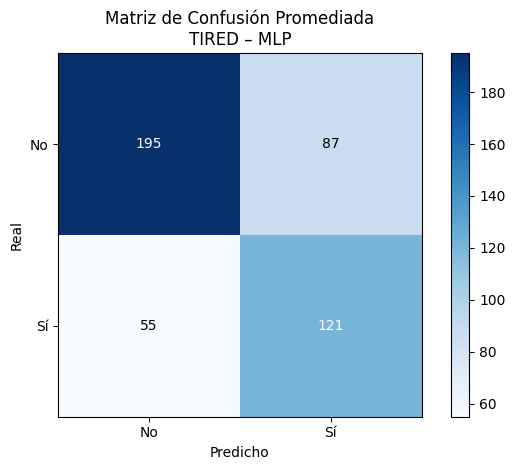

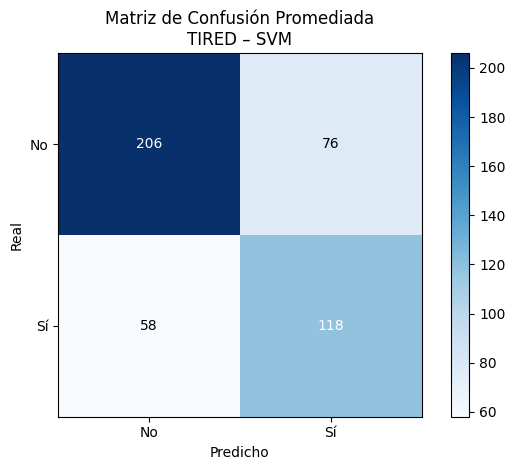

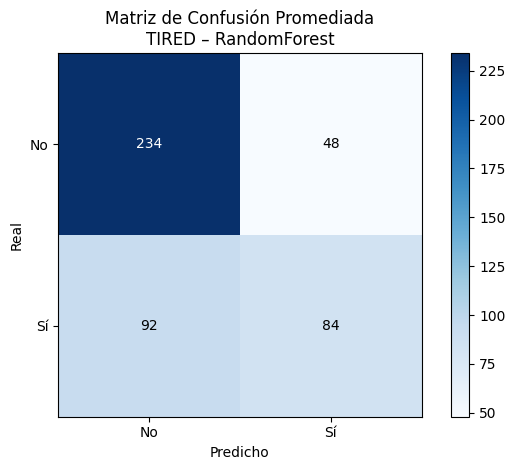

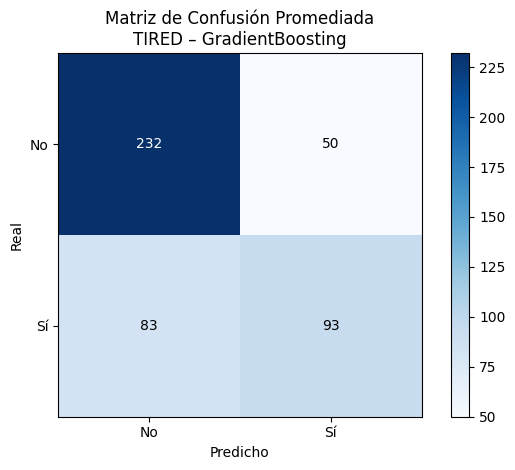

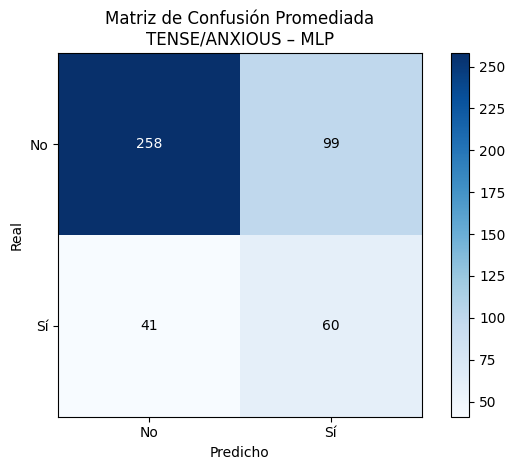

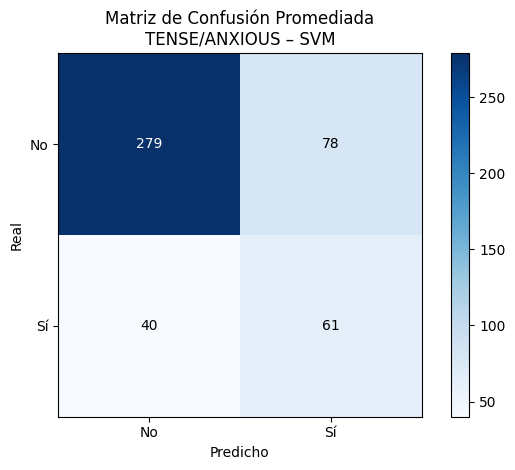

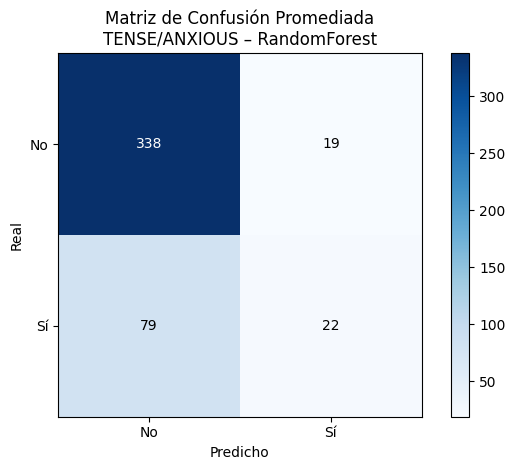

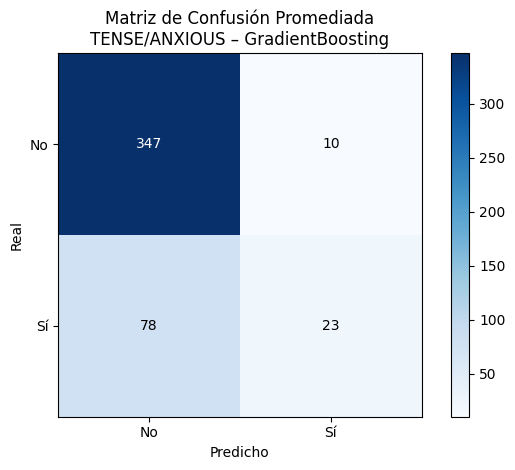

In [17]:
for target in target_cols:
    for model, data in results[target].items():
        # 1. Confusión media (promedio de las 5 seeds)
        cms = [np.array(m["cm"]) for m in data["all_metrics"]]
        cm_mean = np.mean(cms, axis=0).round().astype(int)

        # 2. Visualización
        plt.figure()
        plt.imshow(cm_mean, interpolation="nearest", cmap='Blues')
        plt.title(f"Matriz de Confusión Promediada\n{target} – {model}")
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ["No", "Sí"])
        plt.yticks(tick_marks, ["No", "Sí"])
        plt.ylabel("Real")
        plt.xlabel("Predicho")

        # Anotar cada celda
        thresh = cm_mean.max() / 2.
        for i in range(cm_mean.shape[0]):
            for j in range(cm_mean.shape[1]):
                plt.text(j, i, format(cm_mean[i, j], "d"),
                         ha="center", va="center",
                         color="white" if cm_mean[i, j] > thresh else "black")

        plt.tight_layout()
        plt.show()